Fonte dos dados: [Finbra, STN](https://siconfi.tesouro.gov.br/siconfi/pages/public/consulta_finbra/finbra_list.jsf)

conta |desc|
------|----|
12 |                               Educação
12.361|                      Ensino Fundamental
12.363|                     Ensino Profissional
12.364|                         Ensino Superior
12.365|                       Educação Infantil
12.367|                       Educação Especial
12.999|              Demais Subfunções Educação

In [403]:
import pandas as pd
import geopandas as gp
from altair import *
from nupis import *
%matplotlib inline

In [404]:
x = pd.read_csv('/home/lincoln/Dropbox/dados/financas/financas_municipais/finbra_2015_despesas_por_funcao_liquidadas.csv', 
                sep=';' ,decimal=',', encoding='latin_1', low_memory=False, skiprows=3)
x.columns = x.columns.str.lower()
x.drop('instituição', axis=1, inplace=True)
x = x.join(x.conta.str.split(' - ', expand=True)).drop('conta', axis=1)
x.columns = ['mun', 'uf', 'pop', 'valor', 'cod_conta', 'desc_conta']
x = x.loc[:, ['mun', 'pop', 'cod_conta', 'desc_conta', 'valor']] # tirei uf
# x.rename(columns={'uf':'sigla_uf'}, inplace=True)

atlas = pd.read_csv('atlas.csv')
cod = atlas.loc[:,['nome_mun', 'nome_uf', 'mun', 'uf', 'meso', 'nome_meso', 'micro',
       'nome_micro']]

desp = pd.merge(x, cod, on='mun', how='left')

desp = desp.loc[:, ['nome_mun', 'cod_conta', 'desc_conta', 'valor',
       'uf', 'meso', 'nome_meso', 'micro', 'nome_micro', 'mun', 'pop']]

# transforma as categorias de despesas totais em códigos
desp.cod_conta = desp.cod_conta.str.replace('Despesas \(Exceto Intraorçamentárias\)', '00')
desp.cod_conta = desp.cod_conta.str.replace('Despesas \(Intraorçamentárias\)', '00.1')

In [2]:
# todas as despesas 
# ssm = desp.query(' (cod_conta == "00")  &  (meso == 3110) ')

In [354]:
ssm = desp.query(' (cod_conta == "12.361")  &  (meso == 3110) ')

In [385]:
# faltam dados sobre as seguintes cidades
atlas_ssm = atlas.query('meso == 3110')
set(atlas_ssm.nome_mun).difference(ssm.nome_mun)

{'aiuruoca',
 'carvalhópolis',
 'delfinópolis',
 'fama',
 'jacutinga',
 'marmelópolis',
 'santana da vargem',
 'virgínia'}

In [389]:
faltantes = pd.concat([atlas_ssm[['mun', 'nome_mun']], ssm[['mun', 'nome_mun']]]).drop_duplicates(keep=False)

ssm = pd.concat([ssm, faltantes])

ssm.pc.fillna(ssm.pc.mean(), inplace=True)
ssm.query('nome_mun == "aiuruoca"')


In [357]:
ssm['pc'] = round(ssm.valor / ssm['pop'], 0)

/home/lincoln/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [359]:
ssm.pc.describe()

count     138.000000
mean      433.898551
std       174.619055
min       182.000000
25%       333.750000
50%       392.000000
75%       486.750000
max      1293.000000
Name: pc, dtype: float64

In [358]:
ssm.sort_values(by='pc', ascending=False)[['nome_mun', 'pc']].head(10)

,nome_mun,pc
212524,albertina,1293.0
38918,serranos,1049.0
220420,são sebastião do rio verde,967.0
109575,senador josé bento,961.0
224216,passa-vinte,918.0
23328,consolação,781.0
3759,seritinga,775.0
158026,itapeva,750.0
16409,claraval,741.0
191125,wenceslau braz,739.0


In [360]:
mg = gp.read_file('ssm.shp')
mg.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True) 
mg['mun'] = mg.mun.astype(int)
mg = pd.merge(mg, ssm, on='mun')

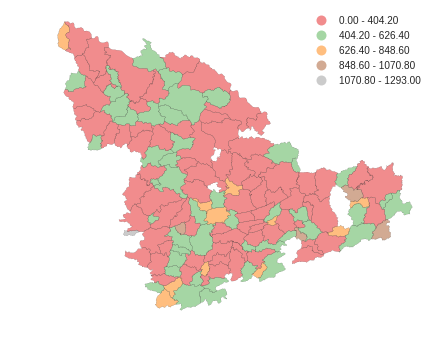

In [363]:
ax = mg.plot('pc', scheme='equal_interval', linewidth=0.1, figsize=(7,7), legend=True, cmap='Set1') 
ax.set_axis_off();

In [364]:
w = ps.queen_from_shapefile('ssm.shp')

In [396]:
IM = ps.Moran(ssm.pc, w)

In [397]:
moran_summary(IM)

Moran Rate Summary Report
I       -0.001   observed value of Moran’s I
EI_sim   -0.008   average value of I from permutations  
p_sim     0.424   p-value based on permutations


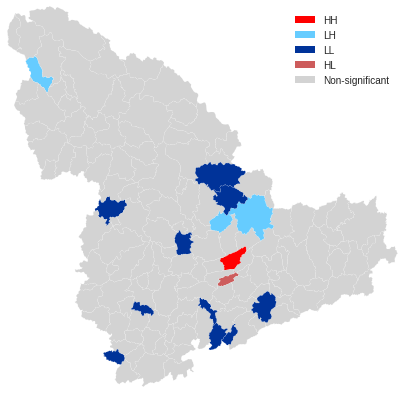

In [398]:
lisa_map(ssm.pc, 'ssm.shp')

### total educação

In [352]:
edu = desp[desp.cod_conta.str.contains('^12$')].query('meso == 3110')

In [19]:
edu['edupc'] = round(edu.valor / edu['pop'], 0)

In [20]:
edu.edupc.describe().round(0)

count     139.0
mean      585.0
std       179.0
min       283.0
25%       478.0
50%       531.0
75%       656.0
max      1450.0
Name: edupc, dtype: float64

In [22]:
edu[['nome_mun', 'edupc']].sort_values(by='edupc', ascending=False).head()

,nome_mun,edupc
212523,albertina,1450.0
220419,são sebastião do rio verde,1194.0
38917,serranos,1159.0
224215,passa-vinte,1063.0
23327,consolação,1054.0


In [27]:
mg = gp.read_file('ssm.shp')
mg.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True) 
mg['mun'] = mg.mun.astype(int)
edu = pd.merge(mg, edu, on='mun')

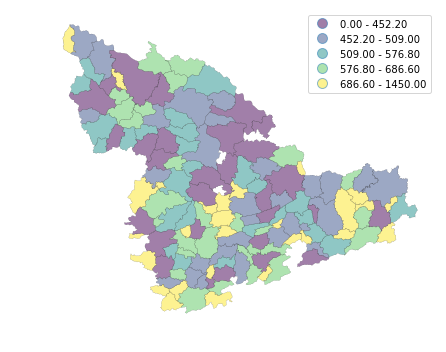

In [28]:
ax = edu.plot('edupc', scheme='quantiles', linewidth=0.1, figsize=(7,7), legend=True) 
ax.set_axis_off();

In [36]:
# faltam dados sobre as seguintes cidades
atlas_ssm = atlas.query('meso == 3110')
faltantes = set(atlas_ssm.nome_mun).difference(ssm.nome_mun)

In [37]:
faltantes

{'carvalhópolis',
 'delfinópolis',
 'fama',
 'jacutinga',
 'marmelópolis',
 'santana da vargem',
 'virgínia'}

In [40]:
[print(i) for i in atlas_ssm.nome_mun.values if i in faltantes]

carvalhópolis
delfinópolis
fama
jacutinga
marmelópolis
santana da vargem
virgínia


[None, None, None, None, None, None, None]

In [43]:
atlas_ssm[atlas_ssm['nome_mun'] in faltantes ]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [1]:
import pandas as pd
import geopandas as gp
import pysal as ps
import palettable
from nupis import *
%matplotlib inline

In [2]:
esc = pd.read_csv('/home/lincoln/Downloads/inep/microdados_saeb_2015/DADOS/TS_ESCOLA.csv', encoding='latin1')

esc.columns = esc.columns.str.lower()
esc.rename(columns={'id_municipio': 'mun'}, inplace=True)
esc['id_dependencia_adm'] = esc['id_dependencia_adm'].astype('category')

atlas = pd.read_csv('atlas.csv').query('meso == 3110')
ssm = pd.merge(atlas.iloc[:,:7], esc, on='mun')
# restringindo a escolas municipais
ssm = ssm.query('id_dependencia_adm == 3')
# agrupando as escolas por cidade

ssm = ssm.groupby('mun')['media_5ef_lp', 'media_5ef_mt'].mean().round(2).reset_index()
ssm = pd.merge(ssm, atlas[['mun', 'nome_mun']], on='mun')

# colocando o shapefile no dataframe
ssm = merge_shp_df('ssm.shp', ssm)
# substituindo NAs pela média
ssm['media_5ef_lp'] = ssm.media_5ef_lp.fillna(ssm.media_5ef_lp.mean())
ssm['media_5ef_mt'] = ssm.media_5ef_mt.fillna(ssm.media_5ef_mt.mean())

ssm = ssm.loc[:, ['nome_mun', 'media_5ef_lp', 'media_5ef_mt', 'mun', 'geometry']]

ssm.head()

,nome_mun,media_5ef_lp,media_5ef_mt,mun,geometry
0,aiuruoca,232.10,245.84,3101201,POLYGON ((-44.69162699999998 -21.7433279966499...
1,alagoa,227.73,250.14,3101300,"POLYGON ((-44.559875 -22.15981799665978, -44.5..."
2,albertina,236.37,248.08,3101409,POLYGON ((-46.53304299999996 -22.1854929966603...
3,alfenas,230.06,242.54,3101607,POLYGON ((-45.94778699999995 -21.1649709966359...
4,alpinopolis,224.49,246.50,3101904,POLYGON ((-46.35793399999996 -20.6863689966242...


In [3]:
set(atlas.nome_mun).difference(ssm.nome_mun)

{'bom_repouso',
 'consolacao',
 'coqueiral',
 'dom_vicoso',
 'estiva',
 'sao_thome_das_letras'}

In [4]:
atlas = merge_shp_df('ssm.shp', atlas)

faltantes = pd.concat([atlas[['mun', 'nome_mun', 'geometry']], 
                       ssm[['mun', 'nome_mun', 'geometry']]]).drop_duplicates(subset='mun')

ssm = pd.merge(ssm.loc[:, ['media_5ef_lp', 'media_5ef_mt','mun']], faltantes, 
               on='mun', how='right')

ssm.media_5ef_lp.fillna(ssm.media_5ef_lp.mean(), inplace=True)
ssm.media_5ef_mt.fillna(ssm.media_5ef_mt.mean(), inplace=True)
ssm = ssm.loc[:, ['nome_mun', 'media_5ef_lp', 'media_5ef_mt', 'mun', 'geometry']]
ssm.head()

,nome_mun,media_5ef_lp,media_5ef_mt,mun,geometry
0,aiuruoca,232.10,245.84,3101201,POLYGON ((-44.69162699999998 -21.7433279966499...
1,alagoa,227.73,250.14,3101300,"POLYGON ((-44.559875 -22.15981799665978, -44.5..."
2,albertina,236.37,248.08,3101409,POLYGON ((-46.53304299999996 -22.1854929966603...
3,alfenas,230.06,242.54,3101607,POLYGON ((-45.94778699999995 -21.1649709966359...
4,alpinopolis,224.49,246.50,3101904,POLYGON ((-46.35793399999996 -20.6863689966242...


In [5]:
ssm.shape

(146, 5)

In [6]:
ssm.query('nome_mun == "estiva"')

,nome_mun,media_5ef_lp,media_5ef_mt,mun,geometry
144,estiva,228.328261,244.762029,3124500,POLYGON ((-45.91937199999997 -22.4081899966656...


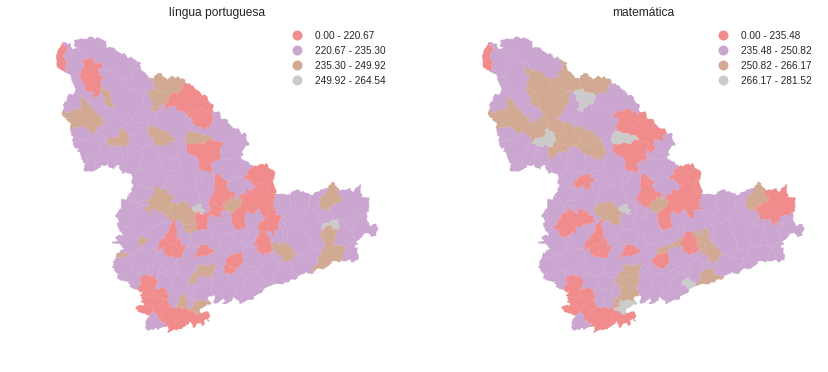

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ssm.plot(column='media_5ef_lp', scheme='equal_interval', k=4,
             linewidth=0, figsize=(7,7), legend=True, cmap='Set1', ax=ax[0])

ssm.plot(column='media_5ef_mt', scheme='equal_interval', k=4,
             linewidth=0, figsize=(7,7), legend=True, cmap='Set1', ax=ax[1])


ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('língua portuguesa')
ax[1].set_title('matemática');

In [21]:
w = ps.queen_from_shapefile('ssm.shp')

IMlp = ps.Moran(ssm.media_5ef_lp, w)

In [22]:
moran_summary(IMlp)

Moran Rate Summary Report
I       -0.016   observed value of Moran’s I
EI_sim   -0.004   average value of I from permutations  
p_sim     0.416   p-value based on permutations


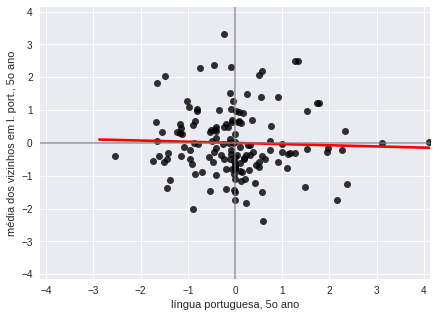

In [24]:
moran_plot(IMlp, xlabel='língua portuguesa, 5o ano', ylabel='média dos vizinhos em l. port., 5o ano')

In [19]:
IMmt = ps.Moran(ssm.media_5ef_mt, w)

moran_summary(IMmt)

Moran Rate Summary Report
I       -0.012   observed value of Moran’s I
EI_sim   -0.008   average value of I from permutations  
p_sim     0.468   p-value based on permutations


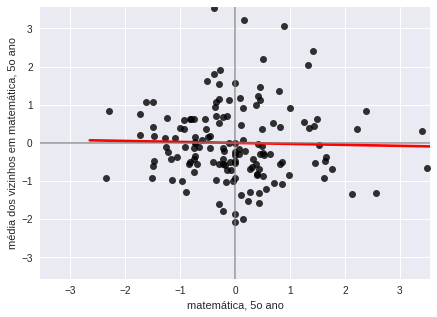

In [20]:
moran_plot(IMmt, xlabel='matemática, 5o ano', ylabel='média dos vizinhos em matemática, 5o ano')

/home/lincoln/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:835: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/lincoln/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/lincoln/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/lincoln/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


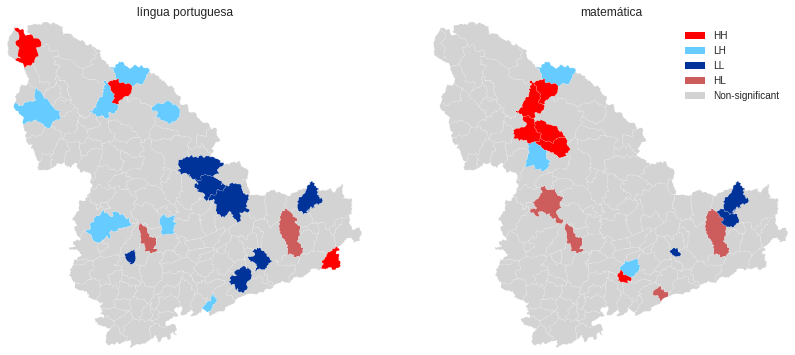

In [30]:
w = ps.queen_from_shapefile('ssm.shp')
shp = ps.open('ssm.shp')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, ps.Moran_Local(ssm.media_5ef_lp, w), p_thres=0.05)
base.set_edgecolor('1')
base.set_linewidth(0.1)
maps.setup_ax([base], [shp.bbox], ax=ax[0])

ax[0].set_title('língua portuguesa')


base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, ps.Moran_Local(ssm.media_5ef_mt, w), p_thres=0.05)
base.set_edgecolor('1')
base.set_linewidth(0.1)
maps.setup_ax([base], [shp.bbox], ax=ax[1])

boxes, labels = maps.lisa_legend_components(ps.Moran_Local(ssm.media_5ef_mt, w), p_thres=0.05)
plt.legend(boxes, labels, fancybox=True)
ax[1].set_title('matemática');

In [305]:
censo = pd.read_csv('/home/lincoln/Downloads/inep/micro_censo_escolar_2016/DADOS/MATRICULA_SUDESTE.CSV', 
                    sep='|', # nrows=10, 
                    usecols=['NU_IDADE', 'TP_ETAPA_ENSINO', 'CO_ENTIDADE', 'CO_MESORREGIAO', 
                             'CO_MICRORREGIAO', 'CO_UF', 'CO_MUNICIPIO', 'CO_DISTRITO', 'TP_DEPENDENCIA', 
                             'TP_LOCALIZACAO', 'TP_CATEGORIA_ESCOLA_PRIVADA'])
# 'NU_ANO_CENSO', 'ID_MATRICULA', 'CO_PESSOA_FISICA', 'NU_DIA', 'NU_MES',
#        'NU_ANO', 'NU_IDADE_REFERENCIA', 'NU_IDADE', 'NU_DURACAO_TURMA',
#        'NU_DUR_ATIV_COMP_MESMA_REDE', 'NU_DUR_ATIV_COMP_OUTRAS_REDES',
#        'NU_DUR_AEE_MESMA_REDE', 'NU_DUR_AEE_OUTRAS_REDES', 'NU_DIAS_ATIVIDADE',
#        'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'CO_PAIS_ORIGEM',
#        'CO_UF_NASC', 'CO_MUNICIPIO_NASC', 'CO_UF_END', 'CO_MUNICIPIO_END',
#        'TP_ZONA_RESIDENCIAL', 'TP_OUTRO_LOCAL_AULA', 'IN_TRANSPORTE_PUBLICO',
#        'TP_RESPONSAVEL_TRANSPORTE', 'IN_TRANSP_VANS_KOMBI',
#        'IN_TRANSP_MICRO_ONIBUS', 'IN_TRANSP_ONIBUS', 'IN_TRANSP_BICICLETA',
#        'IN_TRANSP_TR_ANIMAL', 'IN_TRANSP_OUTRO_VEICULO',
#        'IN_TRANSP_EMBAR_ATE5', 'IN_TRANSP_EMBAR_5A15', 'IN_TRANSP_EMBAR_15A35',
#        'IN_TRANSP_EMBAR_35', 'IN_TRANSP_TREM_METRO', 'IN_NECESSIDADE_ESPECIAL',
#        'IN_CEGUEIRA', 'IN_BAIXA_VISAO', 'IN_SURDEZ', 'IN_DEF_AUDITIVA',
#        'IN_SURDOCEGUEIRA', 'IN_DEF_FISICA', 'IN_DEF_INTELECTUAL',
#        'IN_DEF_MULTIPLA', 'IN_AUTISMO', 'IN_SINDROME_ASPERGER',
#        'IN_SINDROME_RETT', 'IN_TRANSTORNO_DI', 'IN_SUPERDOTACAO',
#        'IN_RECURSO_LEDOR', 'IN_RECURSO_TRANSCRICAO', 'IN_RECURSO_INTERPRETE',
#        'IN_RECURSO_LIBRAS', 'IN_RECURSO_LABIAL', 'IN_RECURSO_BRAILLE',
#        'IN_RECURSO_AMPLIADA_16', 'IN_RECURSO_AMPLIADA_20',
#        'IN_RECURSO_AMPLIADA_24', 'IN_RECURSO_NENHUM', 'TP_INGRESSO_FEDERAIS',
#        'TP_MEDIACAO_DIDATICO_PEDAGO', 'IN_ESPECIAL_EXCLUSIVA', 'IN_REGULAR',
#        'IN_EJA', 'IN_PROFISSIONALIZANTE', 'TP_ETAPA_ENSINO', 'ID_TURMA',
#        'CO_CURSO_EDUC_PROFISSIONAL', 'TP_UNIFICADA', 'TP_TIPO_TURMA',
#        'CO_ENTIDADE', 'CO_REGIAO', 'CO_MESORREGIAO', 'CO_MICRORREGIAO',
#        'CO_UF', 'CO_MUNICIPIO', 'CO_DISTRITO', 'TP_DEPENDENCIA',
#        'TP_LOCALIZACAO', 'TP_CATEGORIA_ESCOLA_PRIVADA', 'IN_CONVENIADA_PP',
#        'TP_CONVENIO_PODER_PUBLICO', 'IN_MANT_ESCOLA_PRIVADA_EMP',
#        'IN_MANT_ESCOLA_PRIVADA_ONG', 'IN_MANT_ESCOLA_PRIVADA_SIND',
#        'IN_MANT_ESCOLA_PRIVADA_SIST_S', 'IN_MANT_ESCOLA_PRIVADA_S_FINS',
#        'TP_REGULAMENTACAO', 'TP_LOCALIZACAO_DIFERENCIADA',
#        'IN_EDUCACAO_INDIGENA']
                                                                                                                  

censo.shape

In [ ]:
c_ssm = censo.query('CO_MESORREGIAO == 3110')
c_ssm.columns = c_ssm.columns.str.lower()
censo = c_ssm
del c_ssm
censo.shape

In [400]:
censo.shape

(612061, 12)

In [399]:
censo.head()

,nu_idade,tp_etapa_ensino,co_entidade,co_mesorregiao,co_microrregiao,co_uf,co_municipio,co_distrito,tp_dependencia,tp_localizacao,tp_categoria_escola_privada,niveis
21930,13,21.0,31180599,3110,31050,31,3170701,317070105,4,1,1.0,fund2
21931,14,21.0,31180599,3110,31050,31,3170701,317070105,4,1,1.0,fund2
21932,14,21.0,31180599,3110,31050,31,3170701,317070105,4,1,1.0,fund2
21933,13,21.0,31180599,3110,31050,31,3170701,317070105,4,1,1.0,fund2
21944,14,21.0,31180599,3110,31050,31,3170701,317070105,4,1,1.0,fund2


In [ ]:
censo['tp_etapa_ensino'] = censo.tp_etapa_ensino.astype('category')
censo['tp_dependencia'] = censo.tp_dependencia.astype('category')

In [402]:
censo.tp_dependencia.value_counts()

2    263984
3    252636
4     82111
1     13330
Name: tp_dependencia, dtype: int64

In [343]:
niveis = []
for row in censo['tp_etapa_ensino']:
    if row == 1:
        niveis.append('creche')
    elif row == 2:
        niveis.append('pre')
    elif row in [4, 5, 6, 7, 14, 15, 16, 17, 18]:
        niveis.append('fund1')
    elif row in [8, 9, 10, 11, 19, 20, 21, 41]:
        niveis.append('fund2')
    elif row in [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]:
        niveis.append('medio')
    elif row in [39, 40, 68]:  # 68:FIC, ?
        niveis.append('tecnico')        
    elif row in [65, 67, 69, 70, 71, 73, 74]:
        niveis.append('eja')        
    else:
        niveis.append('na')        

censo['niveis'] = niveis    

In [349]:
censo.groupby('tp_dependencia').niveis.value_counts()

tp_dependencia  niveis 
1               tecnico     10514
                medio        2620
                eja           154
                na             42
2               fund2       95904
                medio       85849
                eja         32498
                fund1       31408
                na          15826
                tecnico      2491
                pre             7
                creche          1
3               fund1      113284
                pre         48612
                fund2       30743
                creche      28196
                na          25163
                eja          5136
                medio        1316
                tecnico       186
4               fund1       21769
                fund2       15598
                medio       10881
                creche      10763
                pre         10056
                tecnico      5341
                na           4701
                eja          3002
Name: niveis, dtype: int

In [325]:
import seaborn as sns

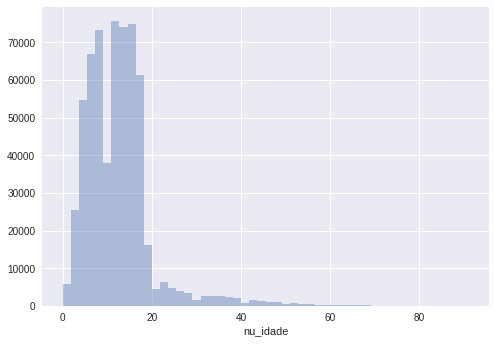

In [328]:
sns.distplot(censo.nu_idade, kde=False);

In [407]:
pd.options.display.max_seq_items = 500
esc = pd.read_csv('/home/lincoln/Downloads/inep/micro_saeb_2015/DADOS/TS_ESCOLA.csv', encoding='latin1')
esc.columns = esc.columns.str.lower()
esc.rename(columns={'id_municipio': 'mun'}, inplace=True)
esc['id_dependencia_adm'] = esc['id_dependencia_adm'].astype('category')

In [408]:
ssm = pd.read_csv('atlas.csv').query('meso == 3110')
ssm = pd.merge(ssm.iloc[:,:7], esc, on='mun')
ssm.id_dependencia_adm.value_counts()

In [168]:
ssm.groupby('id_dependencia_adm')['nu_matriculados_censo_5ef'].sum()

id_dependencia_adm
2     6728.0
3    18830.0
Name: nu_matriculados_censo_5ef, dtype: float64

In [169]:
ssm.groupby('id_dependencia_adm')['nu_matriculados_censo_9ef'].sum()

id_dependencia_adm
2    26547.0
3     6837.0
Name: nu_matriculados_censo_9ef, dtype: float64

In [411]:
ssm.shape

(684, 134)

In [291]:
cidades = ssm.groupby('mun')[['media_5ef_lp', 'media_9ef_lp', 'media_5ef_mt', 'media_9ef_mt']].mean()
cidades = cidades.reset_index()

In [245]:
cidades.head()

,mun,media_5ef_lp,media_9ef_lp,media_5ef_mt,media_9ef_mt
0,3101201,232.100000,292.050000,245.840000,302.570000
1,3101300,227.730000,273.930000,250.140000,294.290000
2,3101409,236.370000,272.070000,248.080000,271.790000
3,3101607,230.268889,267.535714,244.656667,272.824286
4,3101904,227.520000,254.755000,249.096667,266.190000


In [413]:
cc = merge_shp_df('ssm.shp', cidades)

In [414]:
cc['media_5ef_lp'] = cc.media_5ef_lp.fillna(cc.media_5ef_lp.mean())
cc['media_5ef_mt'] = cc.media_5ef_mt.fillna(cc.media_5ef_mt.mean())
cc['media_9ef_lp'] = cc.media_9ef_lp.fillna(cc.media_9ef_lp.mean())
cc['media_9ef_mt'] = cc.media_9ef_mt.fillna(cc.media_9ef_mt.mean())

In [415]:
cc.isnull().sum()

NM_MUNICIP      0
geometry        0
meso            0
mun             0
media_5ef_lp    0
media_9ef_lp    0
media_5ef_mt    0
media_9ef_mt    0
dtype: int64

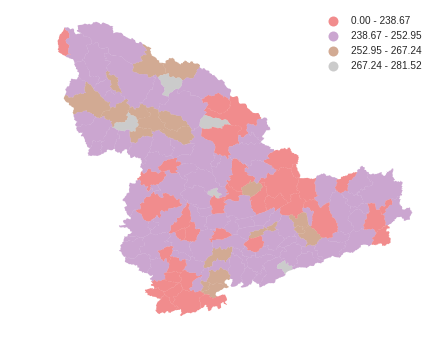

In [288]:
choropleth(cc, 'media_5ef_mt');

In [416]:
w = ps.queen_from_shapefile('ssm.shp')

In [417]:
IM = ps.Moran(cc.media_5ef_lp, w)

In [281]:
moran_df(cc, w)

,variavel,valor
4,media_5ef_mt,0.229725
5,media_9ef_mt,0.173152
3,media_9ef_lp,0.136939
2,media_5ef_lp,0.111126
1,mun,0.046450
0,meso,NaN


In [418]:
moran_summary(IM)

Moran Rate Summary Report
I        0.111   observed value of Moran’s I
EI_sim   -0.004   average value of I from permutations  
p_sim     0.015   p-value based on permutations


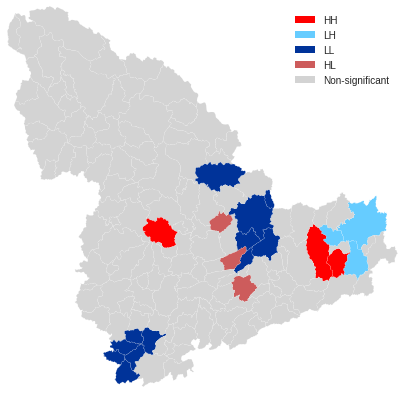

In [419]:
lisa_map(cc.media_5ef_lp, 'ssm.shp')

In [289]:
atlas.query('nome_mun == "varginha"')

,nome_mun,nome_uf,mun,uf,meso,nome_meso,micro,nome_micro,espvida,fectot,...,vab_total,impostos,pib,pibpc,agro,ind,ser,adm,imp,cid_peq
3076,varginha,minas gerais,3170701,31,3110,sul/sudoeste de minas,31050,varginha,77.49,1.5,...,2687935.61,546338.82,3234274.43,26269.29,9.0,211.0,522.0,0.09,169.0,False


In [293]:
cc.query('mun == 3170701')

,NM_MUNICIP,geometry,meso,mun,media_5ef_lp,media_9ef_lp,media_5ef_mt,media_9ef_mt
143,VARGINHA,POLYGON ((-45.36476400000004 -21.4811769966435...,3110,3170701,229.238,269.152105,242.244,271.647895


In [3]:
atlasb = pd.read_csv('atlasb.csv')
malha = '31MUE250GC_SIR.shp'
x = palettable.colorbrewer.qualitative.Set1_6.mpl_colormap 

In [216]:
lista = []
mg = gp.read_file(malha)
mg.geometry = mg.geometry.simplify(0.001) 
mg.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True) 
mg['mun'] = mg.mun.astype(int)

for i in [1991, 2000, 2010]:
    x  = atlasb[atlasb['ano'] == i]
    x  = x[x['meso'] == 3110]
    x = pd.merge(mg, x, on='mun')
    lista.append(x)

s91, s00, s10 = lista

s91 = s91.loc[:, ['nome_mun', 'mun', 'geometry', 'micro', 'nome_micro',  't_flfund']]
s00 = s00.loc[:, ['mun', 't_flfund']]
s10 = s10.loc[:, ['mun', 't_flfund']]

s91.rename(columns={'t_flfund': 'flfund91'}, inplace=True)
s00.rename(columns={'t_flfund': 'flfund00'}, inplace=True)
s10.rename(columns={'t_flfund': 'flfund10'}, inplace=True)

ed = pd.merge(s91, s00, on='mun') 
ed = pd.merge(ed, s10, on='mun') 

In [217]:
ed.head()

,nome_mun,mun,geometry,micro,nome_micro,flfund91,flfund00,flfund10
0,aiuruoca,3101201,POLYGON ((-44.69162699999998 -21.7433279966499...,31055,Andrelândia,77.15,87.76,96.71
1,alagoa,3101300,"POLYGON ((-44.559875 -22.15981799665978, -44.5...",31054,São Lourenço,72.82,94.64,95.02
2,albertina,3101409,POLYGON ((-46.53304299999996 -22.1854929966603...,31051,Poços de Caldas,61.06,91.29,93.64
3,alfenas,3101607,POLYGON ((-45.94778699999995 -21.1649709966359...,31049,Alfenas,81.26,94.90,94.81
4,alpinopolis,3101904,POLYGON ((-46.35793399999996 -20.6863689966242...,31047,Passos,75.34,94.01,93.74


### Resumo estatístico da educação fundamental no Brasil nos três anos

In [218]:
atlasb.query('ano == 1991')['t_flfund'].describe()

count    5565.000000
mean       69.081116
std        14.379128
min         0.000000
25%        61.350000
50%        72.170000
75%        79.570000
max        99.250000
Name: t_flfund, dtype: float64

In [106]:
atlasb.query('ano == 2000')['t_flfund'].describe()

count    5565.000000
mean       89.779544
std         6.730457
min         7.910000
25%        87.550000
50%        91.290000
75%        93.920000
max       100.000000
Name: t_flfund, dtype: float64

In [219]:
atlasb.query('ano == 2010')['t_flfund'].describe()

count    5565.000000
mean       92.945463
std         3.288513
min        47.920000
25%        91.490000
50%        93.370000
75%        94.950000
max       100.000000
Name: t_flfund, dtype: float64

### Resumo estatístico da educação fundamental na SSM nos três anos

In [220]:
ed[['flfund91', 'flfund00', 'flfund10']].describe()

,flfund91,flfund00,flfund10
count,146.000000,146.000000,146.000000
mean,76.802877,90.725959,93.476027
std,6.619560,6.156522,2.748694
min,61.060000,43.980000,78.710000
25%,72.852500,89.342500,92.460000
50%,77.155000,91.735000,93.895000
75%,81.380000,94.437500,95.277500
max,95.170000,100.000000,97.660000


### Mapas não comparáveis

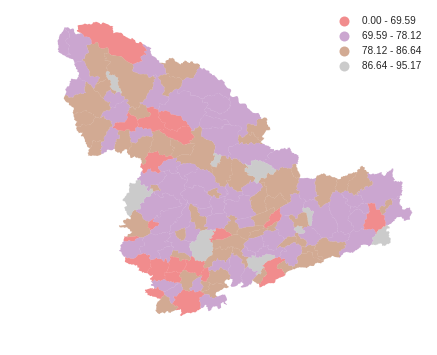

In [221]:
choropleth(ed, 'flfund91')

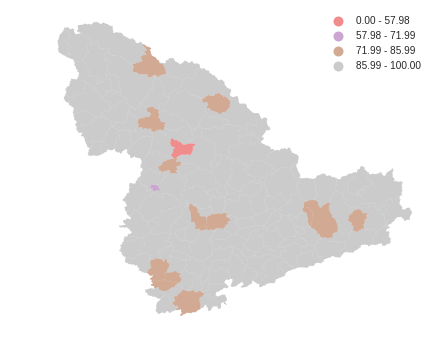

In [222]:
choropleth(ed, 'flfund00')

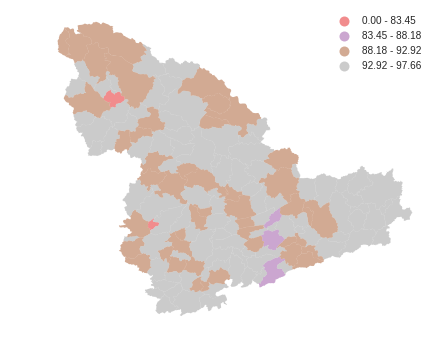

In [223]:
choropleth(ed, 'flfund10')

### Mapas comparáveis

In [224]:
quartil91 = []
quartil00 = []
quartil10 = []

for linha in ed.flfund91:
    if linha <= 83.45:
        quartil91.append('1')
    elif 83.45 < linha <= 88.18:
        quartil91.append('2')
    elif 88.18  < linha <= 92.92:
        quartil91.append('3') 
    else:
        quartil91.append('4')

ed['quartil91'] = quartil91


for linha in ed.flfund00:
    if linha <= 83.45:
        quartil00.append('1')
    elif 83.45 < linha <= 88.18:
        quartil00.append('2')
    elif 88.18  < linha <= 92.92:
        quartil00.append('3') 
    else:
        quartil00.append('4')

ed['quartil00'] = quartil00


for linha in ed.flfund10:
    if linha <= 83.45:
        quartil10.append('1')
    elif 83.45 < linha <= 88.18:
        quartil10.append('2')
    elif 88.18  < linha <= 92.92:
        quartil10.append('3') 
    else:
        quartil10.append('4')

ed['quartil10'] = quartil10

ed['quartil91'] = ed.quartil91.astype(int)
ed['quartil00'] = ed.quartil00.astype(int)
ed['quartil10'] = ed.quartil10.astype(int)

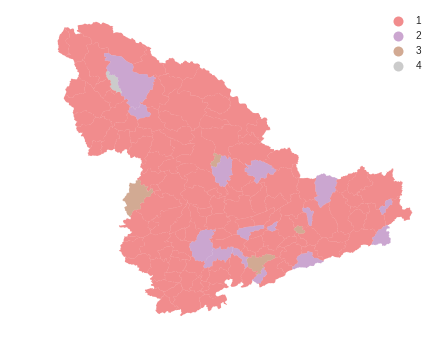

In [72]:
ax = ed.plot(column='quartil91', categorical=True, linewidth=0, figsize=(7,7), legend=True)
ax.set_axis_off();

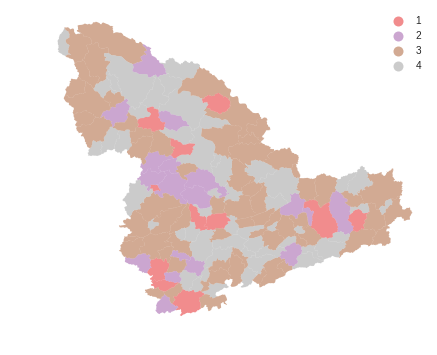

In [73]:
ax = ed.plot(column='quartil00', categorical=True, linewidth=0, figsize=(7,7), legend=True)
ax.set_axis_off();

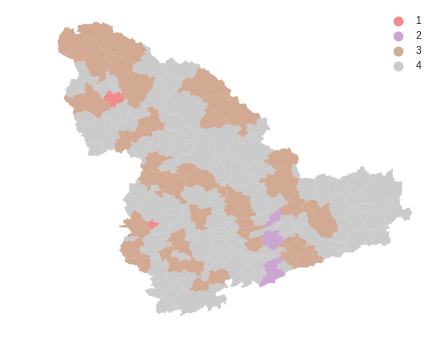

In [74]:
ax = ed.plot(column='quartil10', categorical=True, linewidth=0, figsize=(7,7), legend=True)
ax.set_axis_off();

In [75]:
w = ps.queen_from_shapefile('ssm.shp')

In [76]:
IM91 = ps.Moran(ed.flfund91, w)
IM00 = ps.Moran(ed.flfund00, w)
IM10 = ps.Moran(ed.flfund10, w)

In [77]:
moran_summary(IM91)

Moran Rate Summary Report
I        0.081   observed value of Moran’s I
EI_sim   -0.007   average value of I from permutations  
p_sim     0.053   p-value based on permutations


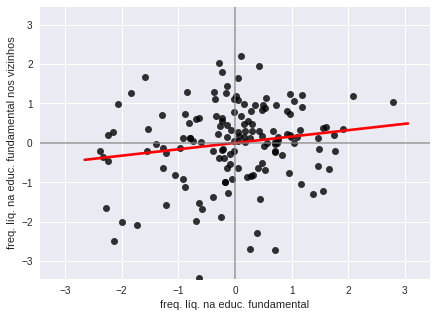

In [108]:
moran_plot(IM91, xlabel='freq. líq. na educ. fundamental', ylabel='freq. líq. na educ. fundamental nos vizinhos')

In [110]:
moran_summary(IM00)

Moran Rate Summary Report
I        0.058   observed value of Moran’s I
EI_sim   -0.007   average value of I from permutations  
p_sim     0.088   p-value based on permutations


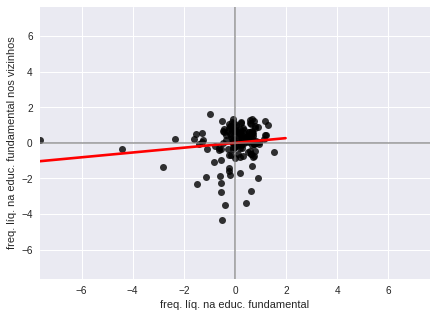

In [111]:
moran_plot(IM00, xlabel='freq. líq. na educ. fundamental', ylabel='freq. líq. na educ. fundamental nos vizinhos')

In [81]:
moran_summary(IM10)

Moran Rate Summary Report
I        0.040   observed value of Moran’s I
EI_sim   -0.008   average value of I from permutations  
p_sim     0.169   p-value based on permutations


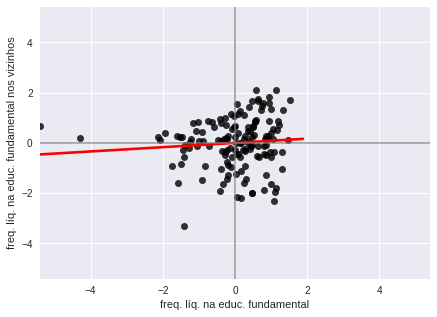

In [112]:
moran_plot(IM10, xlabel='freq. líq. na educ. fundamental', ylabel='freq. líq. na educ. fundamental nos vizinhos')

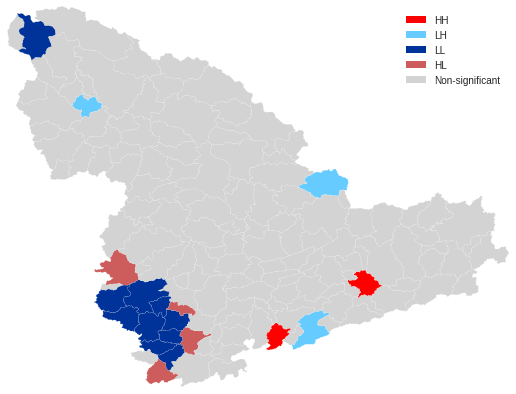

In [83]:
lisa_map(ed.flfund91, 'ssm.shp')

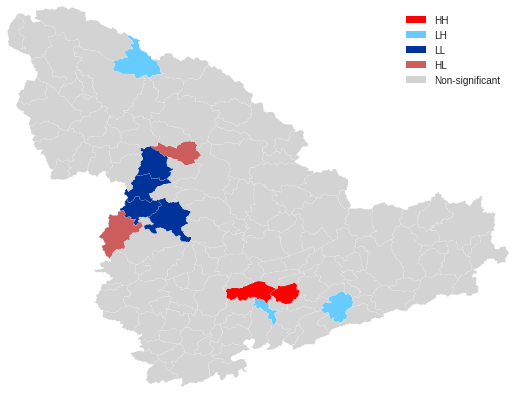

In [84]:
lisa_map(ed.flfund00, 'ssm.shp')

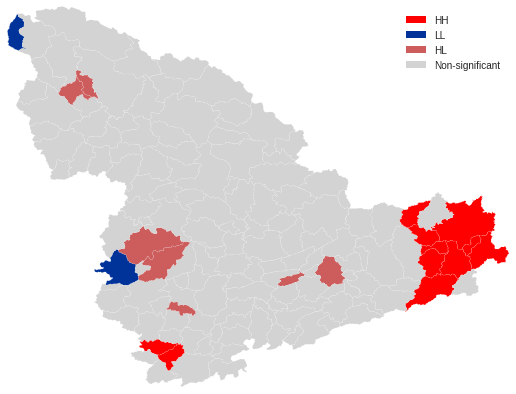

In [85]:
lisa_map(ed.flfund10, 'ssm.shp')

### Testes

In [86]:
moran_df(ed, w)

,variavel,valor
1,micro,0.905307
2,flfund91,0.081088
6,quartil00,0.068984
3,flfund00,0.057711
0,mun,0.046450
4,flfund10,0.040142
5,quartil91,0.019959
7,quartil10,0.004742


In [87]:
IMq91 = ps.Moran(ed.quartil91, w)
IMq00 = ps.Moran(ed.quartil00, w)
IMq10 = ps.Moran(ed.quartil10, w)

In [88]:
moran_summary(IMq91)

Moran Rate Summary Report
I        0.020   observed value of Moran’s I
EI_sim   -0.011   average value of I from permutations  
p_sim     0.246   p-value based on permutations


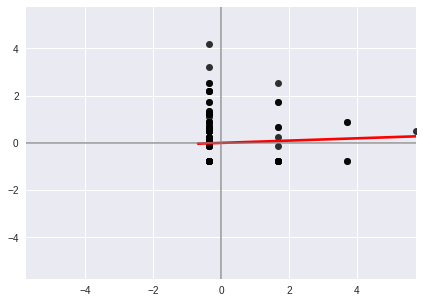

In [113]:
moran_plot(IMq91)

In [90]:
moran_summary(IMq00)

Moran Rate Summary Report
I        0.069   observed value of Moran’s I
EI_sim   -0.006   average value of I from permutations  
p_sim     0.084   p-value based on permutations


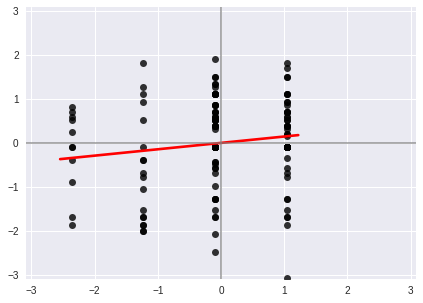

In [91]:
moran_plot(IMq00)

In [92]:
moran_summary(IMq10)

Moran Rate Summary Report
I        0.005   observed value of Moran’s I
EI_sim   -0.007   average value of I from permutations  
p_sim     0.373   p-value based on permutations


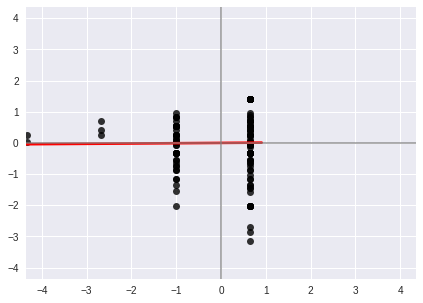

In [93]:
moran_plot(IMq10)

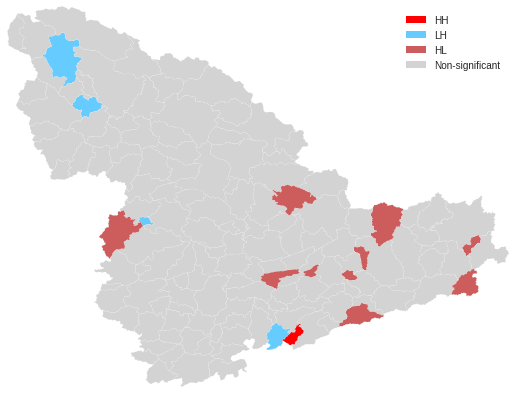

In [94]:
lisa_map(ed.quartil91, 'ssm.shp')

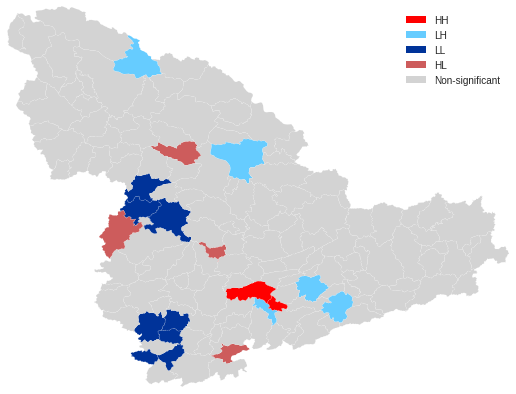

In [95]:
lisa_map(ed.quartil00, 'ssm.shp')

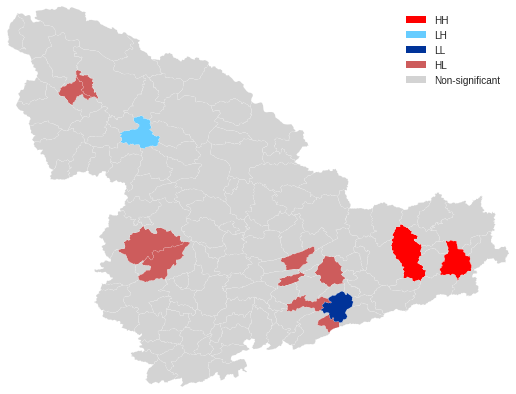

In [96]:
lisa_map(ed.quartil10, 'ssm.shp')